In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

2024-05-21 15:19:18.593951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 15:19:18.720770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 15:19:21.889745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Normal = ['/home/sandeep/shweta/stroke images/Training/Normal']
Stroke= ['/home/sandeep/shweta/stroke images/Training/Stroke']
file_p = []
labels = []
dict_lists = [Normal, Stroke]
class_labels = ['Normal', 'Stroke']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [3]:
df.head()

,filepaths,labels
0,/home/sandeep/shweta/stroke images/Training/No...,Normal
1,/home/sandeep/shweta/stroke images/Training/No...,Normal
2,/home/sandeep/shweta/stroke images/Training/No...,Normal
3,/home/sandeep/shweta/stroke images/Training/No...,Normal
4,/home/sandeep/shweta/stroke images/Training/No...,Normal


In [4]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(1593, 2)
(626, 2)
(282, 2)


In [5]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [6]:
image_gen = ImageDataGenerator(
    rescale=1./255,#Normalisation process
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 1593 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 282 validated image filenames belonging to 2 classes.


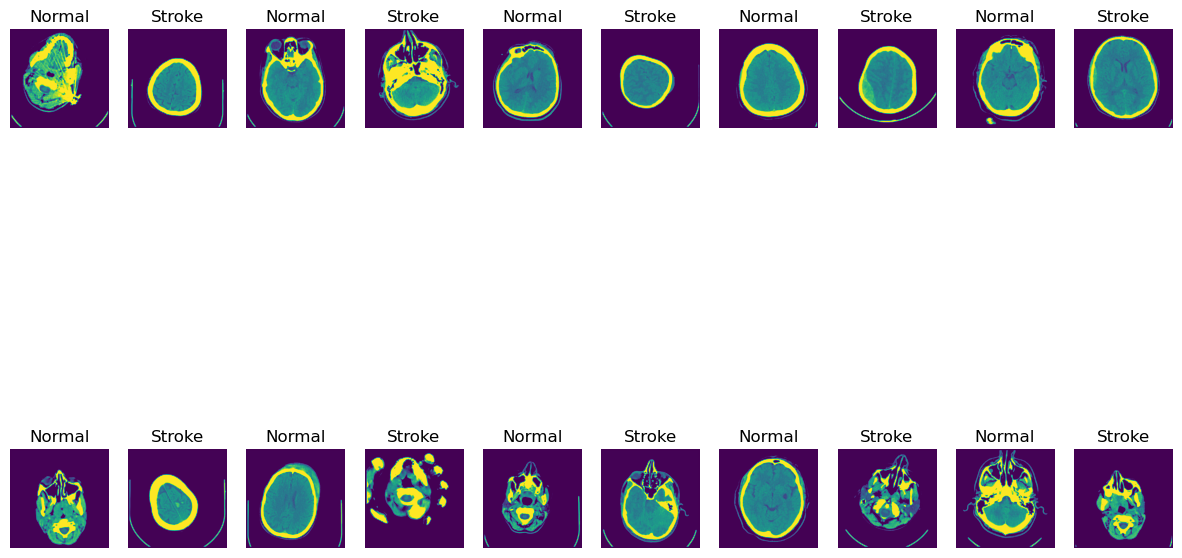

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 393s 16s/step - accuracy: 0.5615 - loss: 4.0337 - val_accuracy: 0.6206 - val_loss: 0.7329
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 520s 19s/step - accuracy: 0.6083 - loss: 0.6974 - val_accuracy: 0.6206 - val_loss: 0.7117
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 510s 19s/step - accuracy: 0.6119 - loss: 0.6850 - val_accuracy: 0.6206 - val_loss: 0.6637
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 474s 19s/step - accuracy: 0.6305 - loss: 0.6529 - val_accuracy: 0.6241 - val_loss: 0.6579
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 483s 19s/step - accuracy: 0.6427 - loss: 0.6468 - val_accuracy: 0.6241 - val_loss: 0.6670
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 477s 19s/step - accuracy: 0.6223 - loss: 0.6640 - val_accuracy: 0.6277 - val_loss: 0.6498
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 480s 19s/step - accuracy: 0.6190 - loss: 0.6471 - val_accuracy: 0.6206 - val_loss: 0.6493
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 478s 19s/step - accuracy: 0.6257 - loss: 0.6610 - val_accuracy: 0.

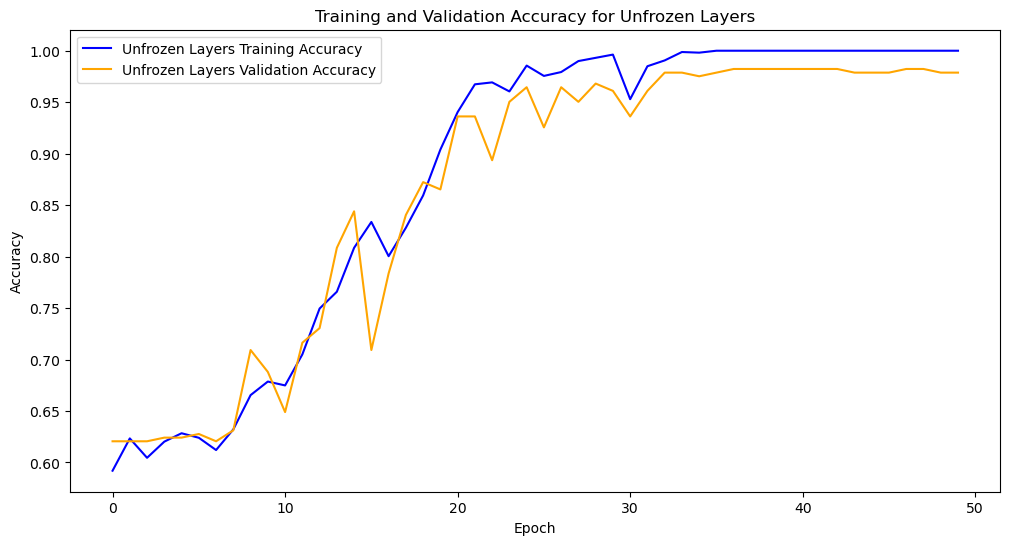

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load VGG16 model with pre-trained weights and without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Define the number of output classes
num_classes = 2  # Example: If you have 2 classes (e.g., Normal and Stroke)

# Add custom dense layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create model with base VGG16 layers frozen and custom dense layers trainable
model_unfreeze = Model(inputs=base_model.input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_unfreeze.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with unfrozen layers
history_unfreeze = model_unfreeze.fit(train, epochs=50, validation_data=val)

import matplotlib.pyplot as plt

# Plot training and validation accuracy for unfrozen layers
plt.figure(figsize=(12, 6))
plt.plot(history_unfreeze.history['accuracy'], label='Unfrozen Layers Training Accuracy', color='blue')
plt.plot(history_unfreeze.history['val_accuracy'], label='Unfrozen Layers Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Unfrozen Layers')
plt.legend()
plt.show()
